In [82]:
import numpy as np
import cv2
from skimage import io
from skimage.feature import peak_local_max
from sklearn.metrics.pairwise import euclidean_distances
from PIL import Image as im
import math
import pickle
from findHomography2d import findHomography2d

import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt

In [2]:
images_folder = './Assignment3files/'
images = ['images2.png', 'images9.png', 'images12.png', 'images20.png']

BLOCK_SIZE = 30
VERT_BLOCKS = 7
HOR_BLOCKS = 9
CORNERS = 4
h_x, h_y = 3, 3
total_imgs = len(images)

In [3]:
# bottom_left, bottom_right, top_right, top_left
# real_coords = [[x_coordinates]
#                [y_coordinates]
#                [z_coordinates]]
ONES = np.ones(CORNERS)
real_coords = np.array([[0, HOR_BLOCKS*BLOCK_SIZE, HOR_BLOCKS*BLOCK_SIZE, 0],
                        [0, 0, VERT_BLOCKS*BLOCK_SIZE, VERT_BLOCKS*BLOCK_SIZE],
                        [*ONES]], dtype = np.float32)

In [4]:
# %matplotlib qt
H_mat = np.zeros((total_imgs, h_x, h_y))
for i, image in enumerate(images):
    image1 = cv2.imread(images_folder+image)
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

    # ginput params=> n: number of mouse clicks, timeout: no. of seconds to wait before timing out (0 = never), show_clicks: TRUE,
    #                 mouse_add: mouse button used to add inputs (MouseButton.LEFT),
    #                 mouse_pop: mouse button used to remove added point (MouseButton.RIGHT), mouse_stop: mouse button used to stop input (MouseButton.MIDDLE)
    plt.figure(figsize=(10, 10), dpi=100)
    plt.imshow(image1)
    plt.title('{}, Start from bottom left in anticlockwise direction'.format(image))
    c1, c2, c3, c4 = plt.ginput(n=4, timeout=0)
    plt.close()

    # bottom_left, bottom_right, top_right, top_left
    # c_mat = [[x_coordinates]
    #          [y_coordinates]
    #          [z_coordinates]]
    c_mat = np.array([[c1[0], c2[0], c3[0], c4[0]], 
                      [c1[1], c2[1], c3[1], c4[1]], 
                      [*ONES]], dtype = np.float32)
    
    H = findHomography2d(real_coords, c_mat)
    H_mat[i] = H / H[-1, -1]
    print('{}\n {}\n'.format(image, np.round_(H_mat[i], 4)))

images2.png
 [[ 1.726400e+00  1.520000e-01  6.694090e+01]
 [ 3.050000e-02 -1.563400e+00  4.106456e+02]
 [-0.000000e+00  4.000000e-04  1.000000e+00]]

images9.png
 [[ 2.198300e+00  6.870000e-02  1.319043e+02]
 [ 2.913000e-01 -1.881100e+00  4.205553e+02]
 [ 1.000000e-03  3.000000e-04  1.000000e+00]]

images12.png
 [[ 1.132900e+00  7.230000e-02  1.032763e+02]
 [-2.760000e-01 -1.411900e+00  3.930284e+02]
 [-8.000000e-04  3.000000e-04  1.000000e+00]]

images20.png
 [[ 1.684300e+00  5.197000e-01  1.275000e+02]
 [-1.460000e-02 -7.783000e-01  2.752134e+02]
 [ 0.000000e+00  1.600000e-03  1.000000e+00]]



In [5]:
def getVectorV(h, i, j):
    return np.array([h[i,0]*h[j,0], h[i,0]*h[j,1]+h[i,1]*h[j,0], h[i,1]*h[j,1], h[i,2]*h[j,0]+h[i,0]*h[j,2], h[i,2]*h[j,1]+h[i,1]*h[j,2], h[i,2]*h[j,2]])

def getMatrixV(H):
    v = np.zeros((2, 6))
    h = np.transpose(H)
    v[0] = getVectorV(h, 0, 1)
    v[1] = getVectorV(h, 0, 0) - getVectorV(h, 1, 1)
    return v

In [6]:
# Compute compound matrix B
V = np.zeros((2*total_imgs, 6))
for i in range(H_mat.shape[0]):
    V[2*i:2*i+2, :] = getMatrixV(H_mat[i])
v_U, v_S, v_V = np.linalg.svd(V)
b = v_V[-1]
B = np.array([[b[0], b[1], b[3]],
     [b[1], b[2], b[4]],
     [b[3], b[4], b[5]]], dtype=np.float32)
print("matrix B:\n {}".format(np.round_(B, 4)))

matrix B:
 [[-0.e+00  0.e+00  5.e-04]
 [ 0.e+00 -0.e+00  3.e-04]
 [ 5.e-04  3.e-04 -1.e+00]]


In [7]:
# Compute intrinsic parameters
v_0 = (B[0,1]*B[0,2] - B[0,0]*B[1,2]) / (B[0,0]*B[1,1] - B[0,1]*B[0,1])
lamda = B[2,2] - (B[0,2]*B[0,2] + v_0*(B[0,1]*B[0,2] - B[0,0]*B[1,2]))/B[0,0]
alpha = math.sqrt(lamda/B[0,0])
beta = math.sqrt((lamda*B[0,0]) / (B[0,0]*B[1,1] - B[0,1]*B[0,1]))
c = (-B[0,1]*alpha*alpha*beta) / lamda
u_0 = ((c*v_0)/alpha) - ((B[0,2]*alpha*alpha) / lamda)

# Intrinsic Matrix
K = np.array([[alpha, c, u_0],
     [0, beta, v_0],
     [0, 0, 1]], np.float32)
print('Intrinsic Matrix (K)\n {}'.format(np.round_(K, 4)))

Intrinsic Matrix (K)
 [[745.0844   1.3561 331.815 ]
 [  0.     723.2172 227.0186]
 [  0.       0.       1.    ]]


In [8]:
# Compute Rotation Matrix and vector T
for i, image in enumerate(images):
    H = H_mat[i]
    lamda = 1 / math.sqrt(sum(np.square(np.linalg.inv(K) @ H[:,0])))
    r1 = lamda * (np.linalg.inv(K) @ H[:,0])
    r2 = lamda * (np.linalg.inv(K) @ H[:,1])
    r3 = np.cross(r1, r2)
    t = lamda * (np.linalg.inv(K) @ H[:,2])
    R = np.transpose(np.array([r1, r2, r3], dtype = np.float32))
    RTR = np.transpose(R) @ R

    r_U, r_S, r_V = np.linalg.svd(R)
    rec_R = r_U @ r_V
    rec_RTR = np.transpose(rec_R) @ rec_R

    print("{}\n ** matrix R **\n {}\n ** vector t **\n {}\n ** matrix RTR **\n {}".format(image, np.round_(R, 4), np.round_(t, 4), np.round_(RTR, 4)))
    print(" ** rec_R **\n {}\n ** rec_RTR **\n {}\n".format(np.round_(rec_R, 4), np.round_(rec_RTR, 4)))

images2.png
 ** matrix R **
 [[ 0.9998  0.0126  0.0012]
 [ 0.0189 -0.9863 -0.1732]
 [-0.0021  0.1732 -0.9864]]
 ** vector t **
 [-153.4523  109.4569  431.0973]
 ** matrix RTR **
 [[ 1.     -0.0064 -0.    ]
 [-0.0064  1.0029  0.    ]
 [-0.      0.      1.0029]]
 ** rec_R **
 [[ 0.9999  0.0158  0.0012]
 [ 0.0157 -0.9848 -0.1729]
 [-0.0016  0.1729 -0.9849]]
 ** rec_RTR **
 [[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]

images9.png
 ** matrix R **
 [[ 0.9242 -0.0084  0.3821]
 [ 0.0298 -0.9955 -0.0952]
 [ 0.3808  0.0996 -0.9198]]
 ** vector t **
 [-99.6518  99.2114 370.7377]
 ** matrix RTR **
 [[ 1.0000e+00  5.0000e-04 -0.0000e+00]
 [ 5.0000e-04  1.0011e+00  0.0000e+00]
 [-0.0000e+00  0.0000e+00  1.0011e+00]]
 ** rec_R **
 [[ 0.9242 -0.0086  0.3819]
 [ 0.0301 -0.995  -0.0952]
 [ 0.3808  0.0995 -0.9193]]
 ** rec_RTR **
 [[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]

images12.png
 ** matrix R **
 [[ 0.915  -0.0096 -0.402 ]
 [-0.0597 -0.9876 -0.1161]
 [-0.3991  0.1311 -0.9042]]
 ** vector t **

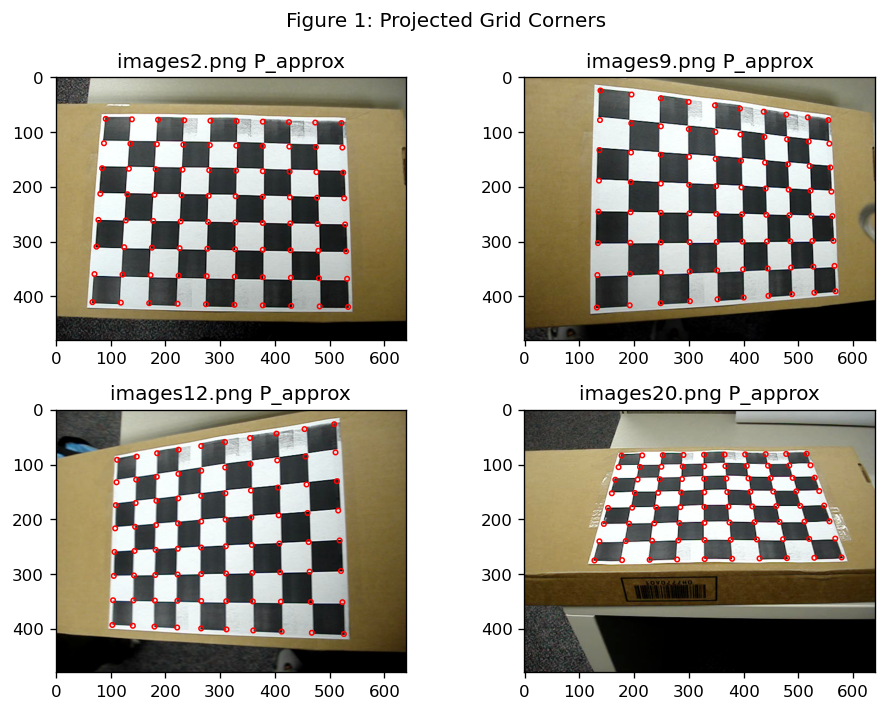

In [76]:
##### IMPROVING ACCURACY #####
%matplotlib inline
fig, axs = plt.subplots(2,math.ceil(len(images)/2))
fig.set_size_inches(8,6)
fig.set_dpi(120.0)
fig.suptitle('Figure 1: Projected Grid Corners')
approx_corners = []
real_corners_mat = []
j = 0
for i, image in enumerate(images):

    if(i/2 == 1):
        j += 1
    H = H_mat[i]
    real_corners = []
    pixel_x = 0

    for x in range(HOR_BLOCKS + 1):
        pixel_y = 0
        for y in range(VERT_BLOCKS + 1):
            real_corners.append([pixel_x, pixel_y])
            pixel_y += BLOCK_SIZE
        pixel_x += BLOCK_SIZE

    real_corners = np.array(real_corners, dtype=np.float32).T
    ones = np.ones((1, real_corners.shape[1]), dtype=np.float32)
    real_corners = np.vstack((real_corners, ones))  # 3 x n
    real_corners_mat.append(real_corners)
    p_approx = H @ real_corners # 3 x n
    p_approx = np.divide(p_approx, np.tile(p_approx[-1], (p_approx.shape[0], 1))) # normalize p_approx by making last row 1
    approx_corners.append(p_approx[:-1,:])
    img = cv2.imread(images_folder+image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[j, i%2].imshow(img)
    axs[j, i%2].set_title("{} P_approx".format(image))
    axs[j, i%2].scatter(p_approx[0], p_approx[1], marker = 'o', facecolors='none', edgecolors='red', s=7.5, linewidths=0.9)

fig.tight_layout()

In [ ]:
# Detect Harris Corners
sigma = 2
thersh = 500
radius = 2

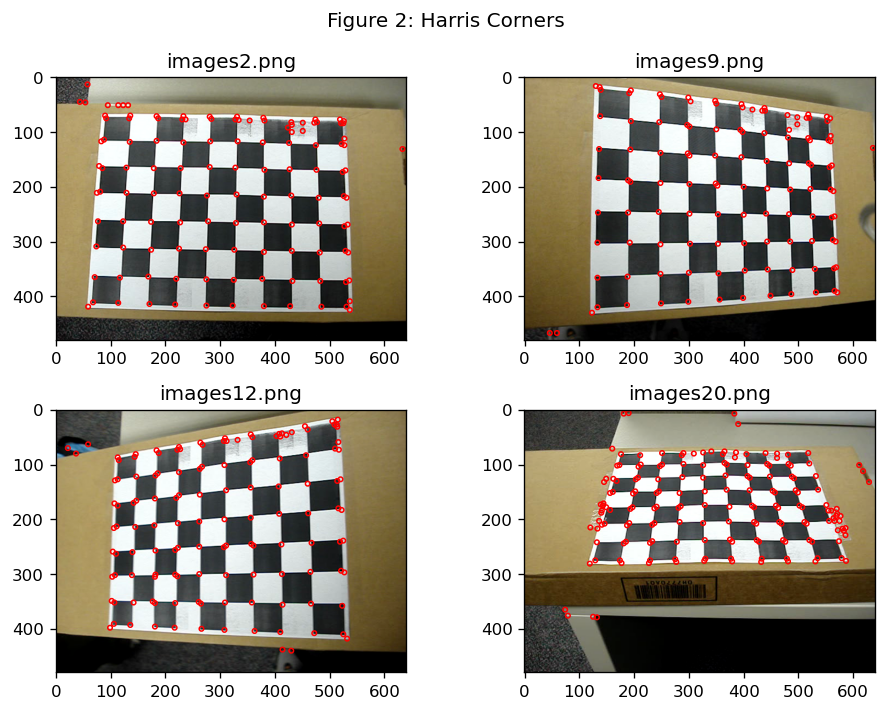

In [77]:
# Detect Harris Corners
%matplotlib inline
fig, axs = plt.subplots(2,math.ceil(len(images)/2))
fig.set_size_inches(8,6)
fig.set_dpi(120.0)
fig.suptitle('Figure 2: Harris Corners')
h_corners = []
j=0
for i, image in enumerate(images):
    if(i/2 == 1):
        j += 1
    
    #part1: harris detection
    img = cv2.imread(images_folder+image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(13,13),2)
    gray = np.float32(gray)

    dst = cv2.cornerHarris(gray, 2, 3, 0.04)

    #part2: Non-Maximum Suppression
    out = peak_local_max(dst, min_distance=3, threshold_abs=500)
    out_t = np.array(out).T
    h_corners.append(np.array([[*out_t[1]], [*out_t[0]]]))
    axs[j, i%2].imshow(img)
    axs[j, i%2].set_title("{}".format(image))
    axs[j, i%2].scatter(out_t[1], out_t[0], marker = 'o', facecolors='none', edgecolors='red', s=7.5, linewidths=0.9)
    # axs[j, i%2].scatter(h_corners[i][0], h_corners[i][1], marker = 'o', facecolors='none', edgecolors='red', s=7.5, linewidths=0.9)
    
fig.tight_layout()

images2.png
 new H matrix:
 [[ 1.74785175e+00  1.60020987e-01  6.34772260e+01]
 [ 2.98519688e-02 -1.59777967e+00  4.14284521e+02]
 [ 4.42425935e-06  4.06508770e-04  1.00000000e+00]]
 err_projection = 0.3551514652818974

images9.png
 new H matrix:
 [[ 2.25151945e+00  7.79611802e-02  1.29021712e+02]
 [ 3.10134180e-01 -1.92295727e+00  4.23885520e+02]
 [ 1.09615217e-03  2.80467950e-04  1.00000000e+00]]
 err_projection = 0.32584087064219236

images12.png
 new H matrix:
 [[ 1.12766194e+00  8.05031894e-02  1.01318206e+02]
 [-2.82614646e-01 -1.42207941e+00  3.93842295e+02]
 [-8.55036581e-04  2.78803574e-04  1.00000000e+00]]
 err_projection = 0.3504815088796816

images20.png
 new H matrix:
 [[ 1.67501676e+00  5.07950826e-01  1.26865090e+02]
 [-1.89767946e-02 -7.91447696e-01  2.75250117e+02]
 [-1.06926564e-05  1.57322817e-03  1.00000000e+00]]
 err_projection = 0.2876557430925058



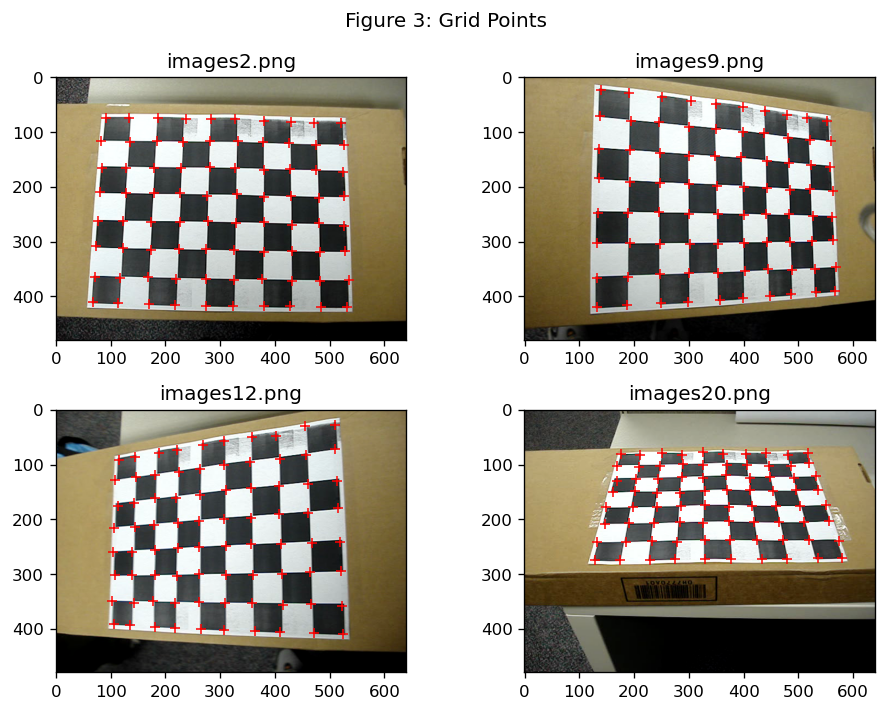

In [79]:
# Compute closest Harris Corners
%matplotlib inline
fig, axs = plt.subplots(2,math.ceil(len(images)/2))
fig.set_size_inches(8,6)
fig.set_dpi(120.0)
fig.suptitle('Figure 3: Grid Points')
j=0
H_rect_mat = np.zeros((total_imgs, h_x, h_y))
err_mat = []

for i, image in enumerate(images):
    if(i/2 == 1):
        j += 1
        
    harris = h_corners[i].T
    approx = approx_corners[i].T
    dist_mat = euclidean_distances(approx, harris, squared=True)
    min_rows = np.argmin(dist_mat, axis=1)
    p_correct = harris[min_rows, :]     # n x 2

    # new H matrix
    ones = np.ones((1, p_correct.T.shape[1]), dtype=np.float32)
    c_mat = np.vstack((p_correct.T, ones))  # 3 x n
    H = findHomography2d(real_corners_mat[i], c_mat)
    H_rect_mat[i] = H / H[-1, -1]

    # error reprojection
    img_corners = H_rect_mat[i] @ real_corners_mat[i]
    img_corners = np.divide(img_corners, np.tile(img_corners[-1], (img_corners.shape[0], 1))) # normalize p_approx by making last row 1
    err_reprojection = math.sqrt(sum(np.sum(np.square(img_corners - c_mat), axis=0))) / img_corners.shape[1]
    err_mat.append(err_reprojection)
    
    img = cv2.imread(images_folder+image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[j, i%2].imshow(img)
    axs[j, i%2].set_title("{}".format(image))
    axs[j, i%2].scatter(p_correct[:,0], p_correct[:,1], marker='+', color = 'red', linewidth=0.9)

fig.tight_layout()

for i, image in enumerate(images):
    print('{}\n new H matrix:\n {}\n err_projection = {}\n'.format(image, H_rect_mat[i], err_mat[i]))

In [81]:
# estimate K, R and t

# compute matrix B
V_new = np.zeros((2*total_imgs, 6))
for i in range(H_rect_mat.shape[0]):
    V_new[2*i:2*i+2, :] = getMatrixV(H_rect_mat[i])
vn_U, vn_S, vn_V = np.linalg.svd(V)
b = vn_V[-1]
B = np.array([[b[0], b[1], b[3]],
     [b[1], b[2], b[4]],
     [b[3], b[4], b[5]]], dtype=np.float32)
print("New B:\n {}\n".format(np.round_(B, 4)))

# Compute intrinsic parameters
v_0 = (B[0,1]*B[0,2] - B[0,0]*B[1,2]) / (B[0,0]*B[1,1] - B[0,1]*B[0,1])
lamda = B[2,2] - (B[0,2]*B[0,2] + v_0*(B[0,1]*B[0,2] - B[0,0]*B[1,2]))/B[0,0]
alpha = math.sqrt(lamda/B[0,0])
beta = math.sqrt((lamda*B[0,0]) / (B[0,0]*B[1,1] - B[0,1]*B[0,1]))
c = (-B[0,1]*alpha*alpha*beta) / lamda
u_0 = ((c*v_0)/alpha) - ((B[0,2]*alpha*alpha) / lamda)

# Intrinsic Matrix
K = np.array([[alpha, c, u_0],
     [0, beta, v_0],
     [0, 0, 1]], np.float32)
print('New Intrinsic Matrix (K)\n {}\n'.format(np.round_(K, 4)))

# Compute Rotation Matrix and vector T
R_list = []
t_list = []
for i, image in enumerate(images):
    H = H_rect_mat[i]
    lamda = 1 / math.sqrt(sum(np.square(np.linalg.inv(K) @ H[:,1])))
    r1 = lamda * (np.linalg.inv(K) @ H[:,0])
    r2 = lamda * (np.linalg.inv(K) @ H[:,1])
    r3 = np.cross(r1, r2)
    t = lamda * (np.linalg.inv(K) @ H[:,2])
    R = np.transpose(np.array([r1, r2, r3], dtype = np.float32))
    R_list.append(R)
    t_list.append(t)

    print("{}\n ** matrix R **\n {}\n ** vector t **\n {}\n".format(image, np.round_(R, 4), np.round_(t, 4)))

New B:
 [[-0.e+00  0.e+00  5.e-04]
 [ 0.e+00 -0.e+00  3.e-04]
 [ 5.e-04  3.e-04 -1.e+00]]

New Intrinsic Matrix (K)
 [[745.0844   1.3561 331.815 ]
 [  0.     723.2172 227.0186]
 [  0.       0.       1.    ]]

images2.png
 ** matrix R **
 [[ 0.988   0.016   0.0047]
 [ 0.0168 -0.9851 -0.1693]
 [ 0.0019  0.1714 -0.9735]]
 ** vector t **
 [-152.0129  109.1507  421.5375]

images9.png
 ** matrix R **
 [[ 0.9175 -0.0055  0.398 ]
 [ 0.0307 -0.9948 -0.0954]
 [ 0.397   0.1016 -0.9126]]
 ** vector t **
 [-98.7487  98.582  362.1541]

images12.png
 ** matrix R **
 [[ 0.914  -0.006  -0.4167]
 [-0.059  -0.9909 -0.1205]
 [-0.4125  0.1345 -0.906 ]]
 ** vector t **
 [-149.4544  111.2883  482.459 ]

images20.png
 ** matrix R **
 [[ 1.0078 -0.0072 -0.0106]
 [-0.0102 -0.7104 -0.7092]
 [-0.0048  0.7037 -0.716 ]]
 ** vector t **
 [-123.0983   29.8319  447.32  ]



In [83]:
# save H, K, R and t
# index -> 0:'images2.png' 1:'images9.png' 2:'images12.png' 3:'images20.png']
open_file = open('H_matrix.pkl', "wb")
pickle.dump(H_rect_mat, open_file)
open_file.close()

open_file = open('K_matrix.pkl', "wb")
pickle.dump(K, open_file)
open_file.close()

open_file = open('Rotation.pkl', "wb")
pickle.dump(R_list, open_file)
open_file.close()

open_file = open('Translation.pkl', "wb")
pickle.dump(t_list, open_file)
open_file.close()